In [3]:
from google.colab import drive
drive.mount('drive') #only run this once

Mounted at drive


In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
!git clone https://github.com/bearpelican/musicautobot.git

Cloning into 'musicautobot'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 3856 (delta 8), reused 14 (delta 4), pack-reused 3830
Receiving objects: 100% (3856/3856), 82.12 MiB | 25.90 MiB/s, done.
Resolving deltas: 100% (2791/2791), done.


In [6]:
import os
os.chdir('musicautobot')

In [7]:
!apt install musescore fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon bind9-host desktop-file-utils fluid-soundfont-gm
  fluidr3mono-gm-soundfont geoclue-2.0 geoip-database
  gstreamer1.0-plugins-base iio-sensor-proxy libavahi-core7 libavahi-glib1
  libbind9-160 libbrotli1 libcap2-bin libcdparanoia0 libdaemon0 libdns1100
  libfluidsynth1 libgeoclue-2-0 libgeoip1 libgl1-mesa-glx
  libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libhyphen0 libisc169
  libisccc160 libisccfg160 liblwres160 libmbim-glib4 libmbim-proxy libmm-glib0
  libnl-genl-3-200 libnss-mdns liborc-0.4-0 libpam-cap libportaudio2
  libpulsedsp libqmi-glib5 libqmi-proxy libqt5help5 libqt5positioning5
  libqt5qml5 libqt5quick5 libqt5sensors5 libqt5sql5-sqlite libqt5svg5
  libqt5webchannel5 libqt5webkit5 libqt5x11extras5 libqt5xmlpatterns5
  libvisual-0.4-0 libwoff1 modemmanager musescore-common pulseaudio-utils
  qml-module-qtgraph

In [8]:
!pip install torch fastai music21 pebble fluidsynth midi2audio

  Created wheel for fluidsynth: filename=fluidsynth-0.2-cp36-none-any.whl size=4516 sha256=a81c75f516ad4bae9d67d0eabc311041fa2d442d47a9c6aed30db004b64ea333
  Stored in directory: /root/.cache/pip/wheels/2d/70/4d/ffe2589bbfe9c268780570a6875583fbf59547004459e2c3c3
Successfully built fluidsynth


In [9]:
print(os.getcwd())

/content/musicautobot


In [10]:
from musicautobot.numpy_encode import *
from musicautobot.config import *
from musicautobot.music_transformer import *

## MusicTransformer Training

MusicTransformer takes the basic idea of [Language Models](https://en.wikipedia.org/wiki/Language_model) and applies it to Music.  

Given a sequence of notes, predict the next most likely set of notes.

This model is based off of [transformer-XL](https://arxiv.org/abs/1901.02860) and uses fast.ai's [implementation](https://github.com/fastai/fastai/blob/master/fastai/text/models/transformer.py) of it.

In [15]:
# Location of your midi filesfiles
midi_path = Path('../midi_data')
midi_path.mkdir(parents=True, exist_ok=True)

# Location to save dataset
data_path = Path('../output')
data_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'musicitem_data_save.pkl'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [16]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

4

In [17]:
processors = [Midi2ItemProcessor()]
data = MusicDataBunch.from_files(midi_files, data_path, processors=processors, bs=2, bptt=12)
data.save(data_save_name)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [18]:
# Show Data
data.train_dl.on_epoch_begin()
x, y = data.one_batch();
x, y

(tensor([[[  0,   0],
          [  1,   0],
          [ 64,   0],
          [138,   0],
          [ 52,   0],
          [138,   0],
          [  8,   0],
          [138,   0],
          [ 63,   1],
          [138,   1],
          [ 51,   1],
          [138,   1]],
 
         [[139, 586],
          [ 90, 588],
          [138, 588],
          [ 87, 588],
          [138, 588],
          [ 83, 588],
          [138, 588],
          [ 66, 588],
          [138, 588],
          [ 51, 588],
          [139, 588],
          [ 44, 588]]]), tensor([[[  1,   0],
          [ 64,   0],
          [138,   0],
          [ 52,   0],
          [138,   0],
          [  8,   0],
          [138,   0],
          [ 63,   1],
          [138,   1],
          [ 51,   1],
          [138,   1],
          [  8,   1]],
 
         [[ 90, 588],
          [138, 588],
          [ 87, 588],
          [138, 588],
          [ 83, 588],
          [138, 588],
          [ 66, 588],
          [138, 588],
          [ 51, 588],
  

## 3. Load Model

In [25]:
batch_size = 1
encode_position = True
dl_tfms = [batch_position_tfm] if encode_position else []
data = load_data(data_path, data_save_name, bs=batch_size, encode_position=encode_position, dl_tfms=dl_tfms)

In [26]:
config = default_config()
config['encode_position'] = encode_position
learn = music_model_learner(data, config=config.copy())

## 4. Train

In [28]:
learn.fit_one_cycle(30)
#learn.recorder.plot_losses()

In [29]:
learn.save('example')

PosixPath('../output/models/example.pth')

## 5. Predict

---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

In [57]:
#we run the prediction on a piece of music it has not seen before
midi_file = Path('/content/musicautobot/data/midi/examples/A Thousand Miles - Vanessa Carlton - Verse-And-Pre-Chorus.mid'); midi_file
item = MusicItem.from_file(midi_file, data.vocab);

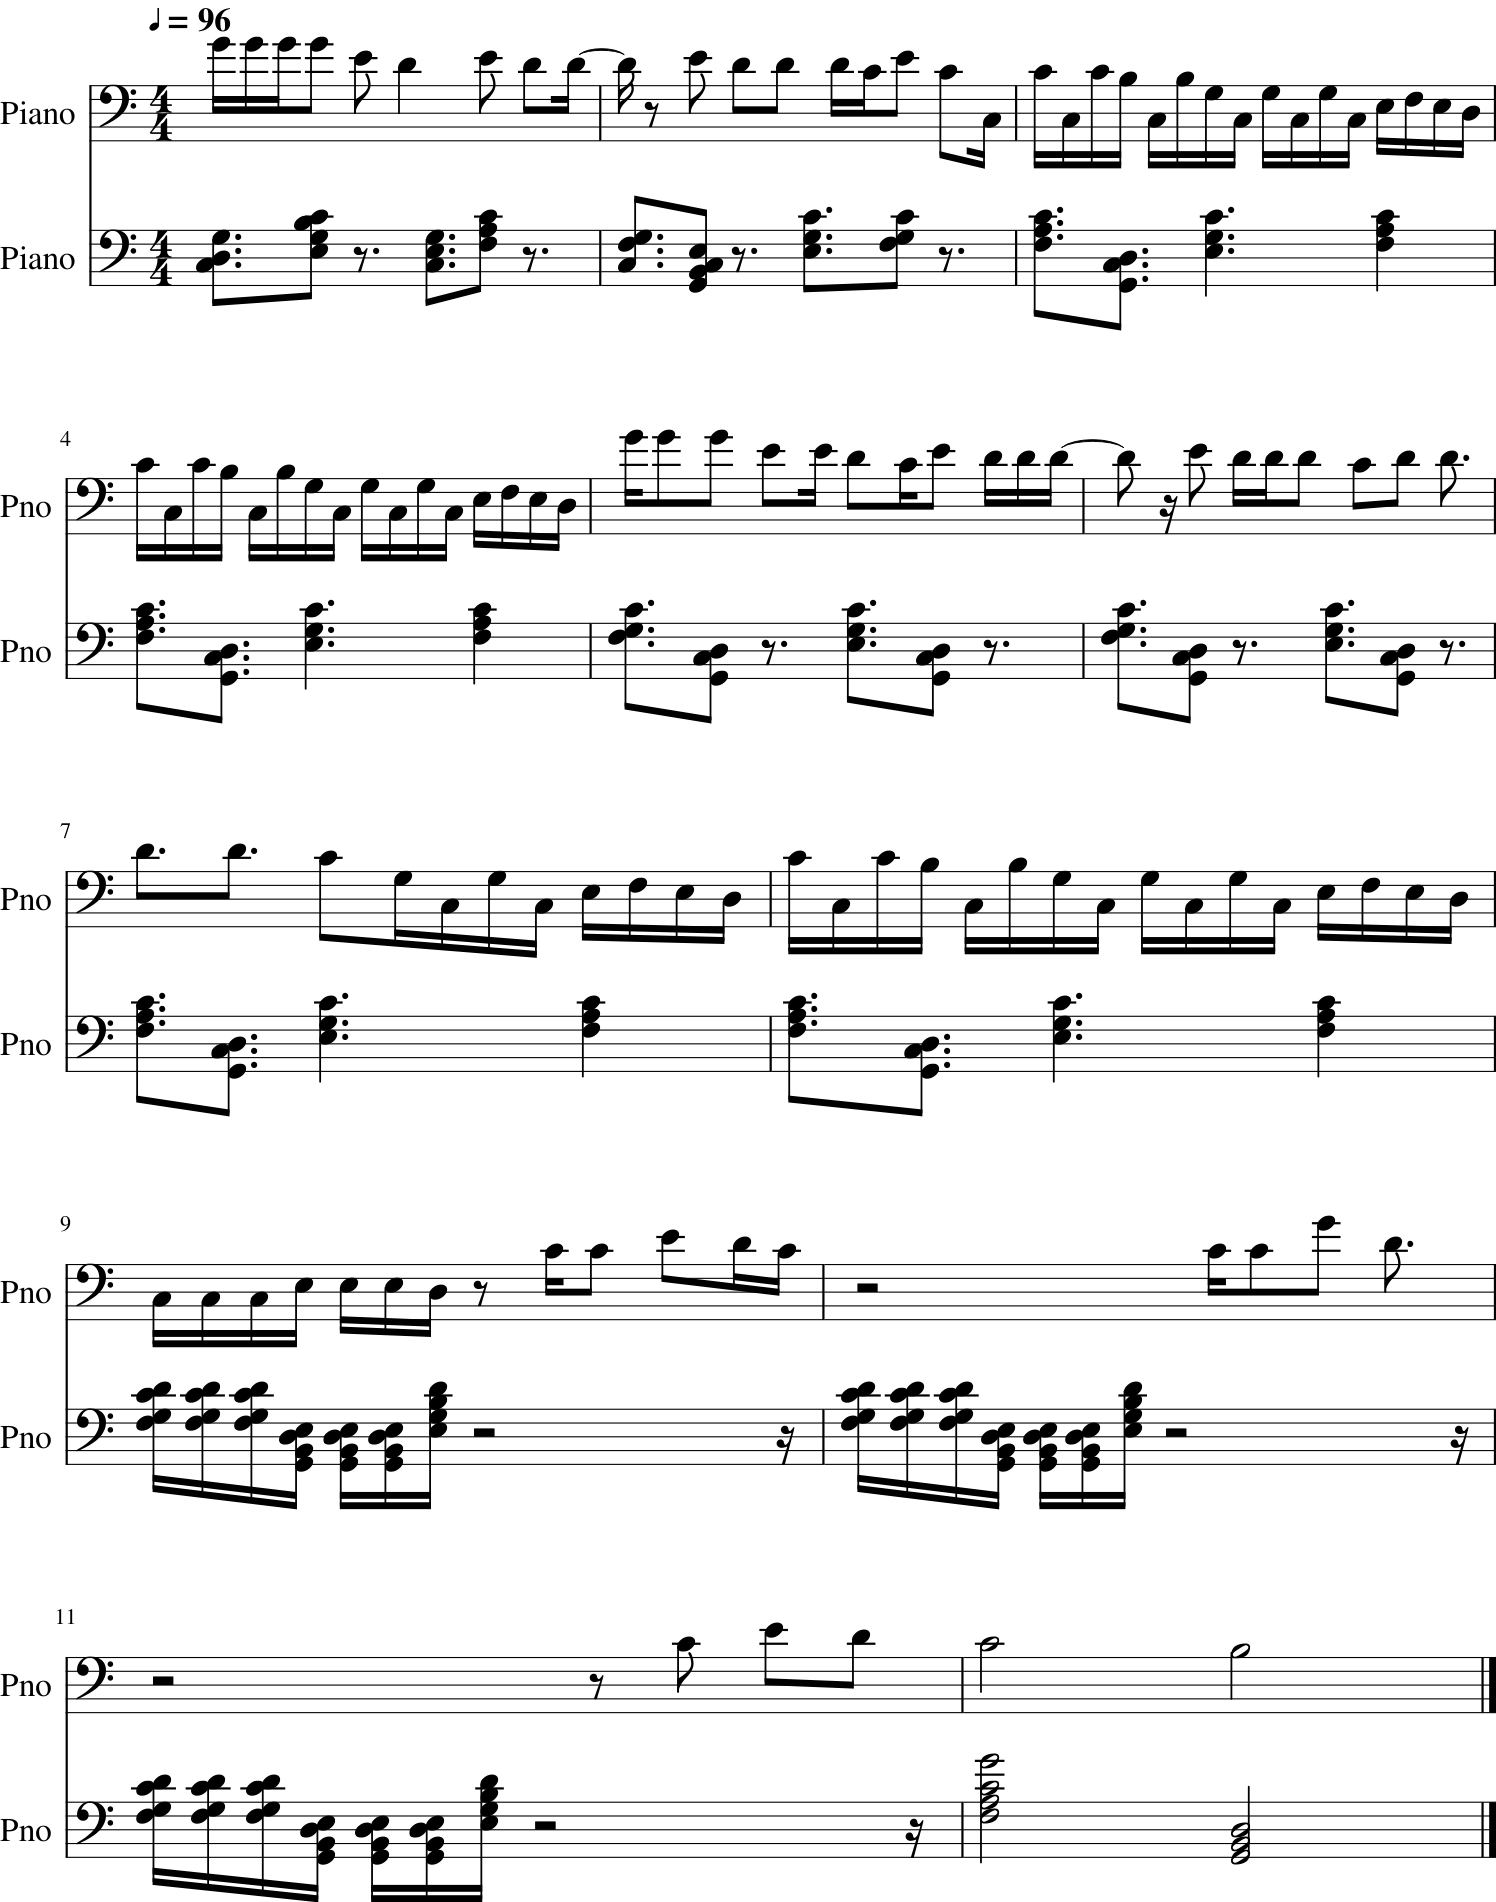

In [58]:
item.show()

Here's what the seed sounds like:

### Start Predictions:

In [59]:
pred, full = learn.predict(item, n_words=100)

Prediction

Non midi note detected. Only returning valid portion. Index, seed 437 (487, 2)


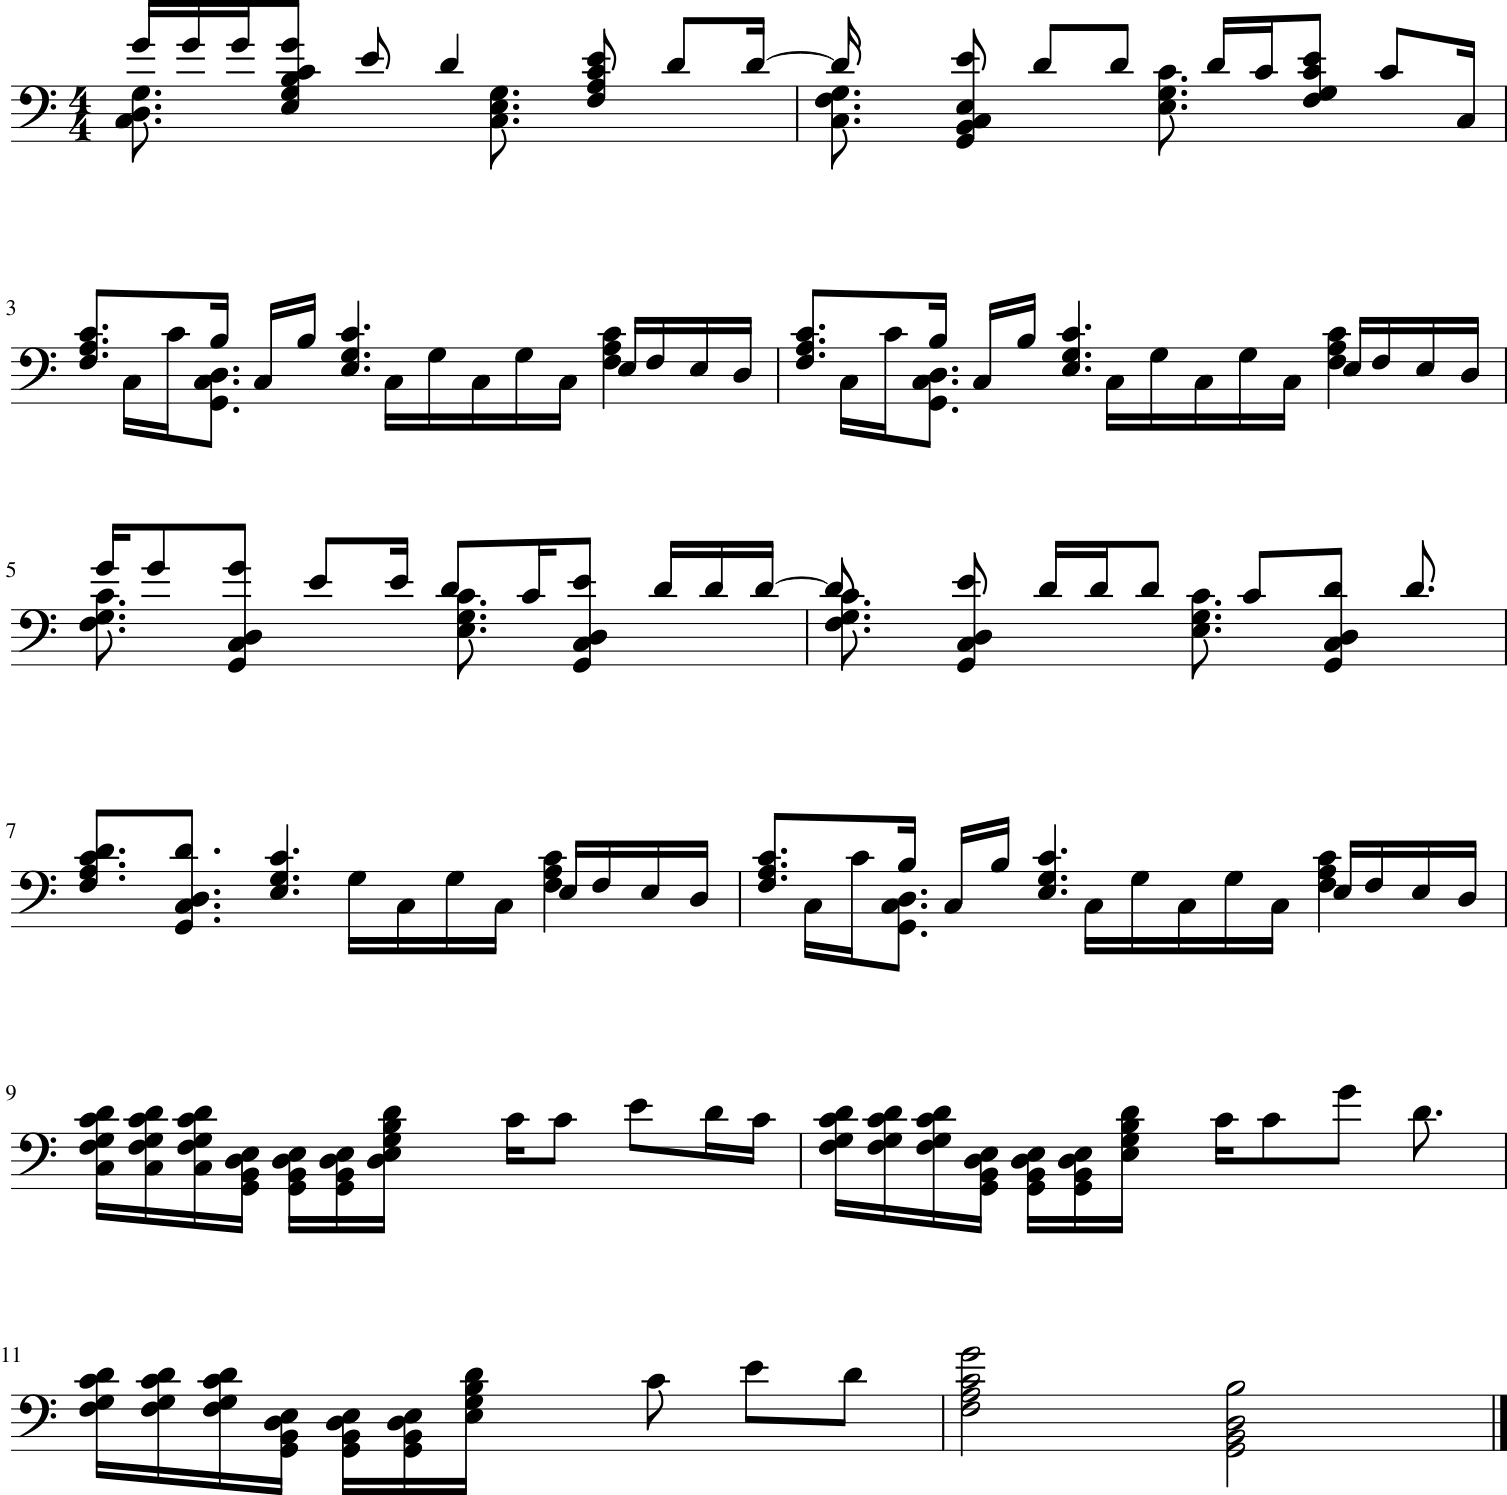

In [60]:
# Prediction
full.show()

In [61]:
from midi2audio import FluidSynth
from IPython.display import Audio
import librosa.display

def save_wav(stream):
    out_midi = stream.write('midi')
    out_wav = str(Path(out_midi).with_suffix('.wav'))
    FluidSynth("font.sf2").midi_to_audio(out_midi, out_wav)
    return Audio(out_wav)



In [63]:
song_output = save_wav(full.stream)
song_output